### AB42: DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
### AB40: DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV


In [1]:
# !pip install MDAnalysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

In [ ]:
# 1. Confirmed that at pH 8.5, the NE1 nitrogen in histidine is protonated based on experimental data. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4082993/

# 2. Changed aminoacids.c.tdb OH to OH1. Potential typo in force field files.

In [ ]:
# using hydrogen mass repartitioning for longer timesteps
gmx_mpi pdb2gmx -f template.pdb -o template.gro -ignh -heavyh -water tip3

cd setup

gmx_mpi editconf -f ../template.gro -o template_newbox.gro -c -d 2 -bt dodecahedron

gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top
# Number of solvent molecules:  13715

In [ ]:
# 1 – energy minimisation
# 2 – NVT 600K to get replica structures

In [ ]:
# Step 1
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c template_solv.gro -p ../topol.top -o em_input.tpr -maxwarn 2

# Got the following warning
# WARNING 1 [file ffnonbonded.itp, line 68]:
#   Atomtype OT was defined previously (e.g. in the forcefield files), and
#   has now been defined again. This could happen e.g. if you would use a
#   self-contained molecule .itp file that duplicates or replaces the
#   contents of the standard force-field files. You should check the contents
#   of your files and remove such repetition. If you know you should override
#   the previous definition, then you could choose to suppress this warningb
#   with -maxwarn.

gerun gmx_mpi mdrun -s em -v -maxh 5 &> em_terminal.log

In [ ]:
# Step 2

gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em_output.gro -r em_output.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr_terminal.log

In [ ]:
# Step 3

gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

In [ ]:
# Step 4

gmx_mpi grompp -f ../mdp_files/4-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 4-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal.log

# restarting step 4
gerun gmx_mpi mdrun -cpi 4-nvt-600 -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal-r2.log

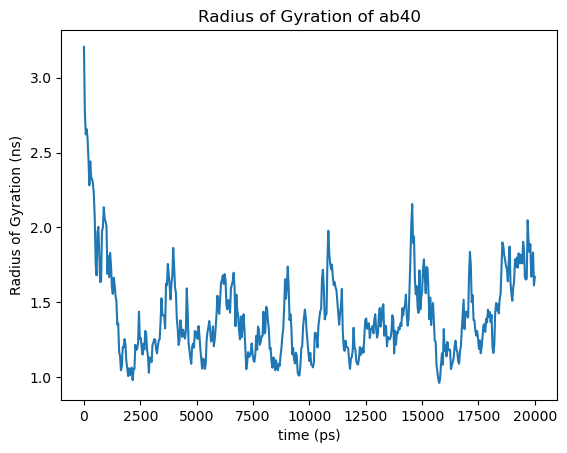

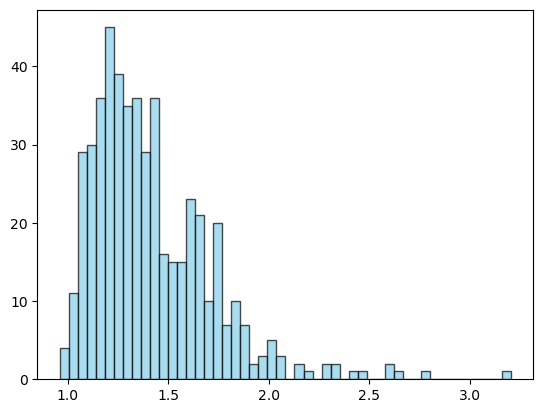

(array([1], dtype=int64),)
1.96781


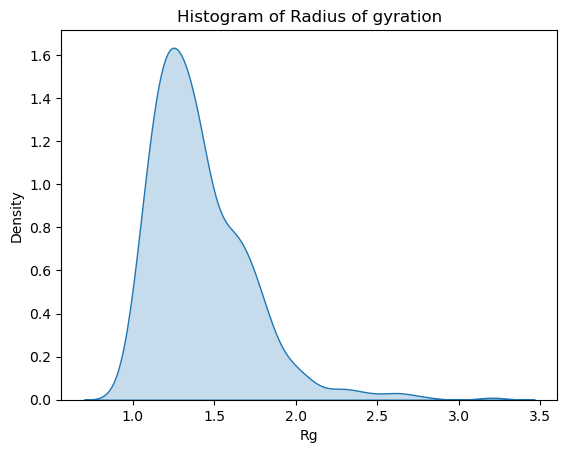

In [23]:
# Plotting the radius of gyration of the peptide in the trajectory

# gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600.trr -o 4-nvt-600-noPBC.trr -pbc mol -center

# gmx_mpi gyrate -s 4-nvt-600.gro -f 4-nvt-600-noPBC.trr -o 4-nvt-600-rgyr.xvg

data = pd.read_table("4-nvt-600-rgyr.xvg", delim_whitespace=True, skiprows=27, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

sorted_y = sorted(y)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("Radius of Gyration (ns)")  # Add a y-label to the axes.
ax.set_title("Radius of Gyration of ab40")
plt.show()
plt.hist(sorted_y, bins=50, edgecolor='black', color='skyblue', alpha=0.7)

indices = np.where(y == 2.77667)
plt.show()

print(indices)
print(sorted_y[476])
import seaborn as sns
import matplotlib.pyplot as plt

# Create a KDE plot
sns.kdeplot(y, fill=True)

# Add title and labels
plt.title('Histogram of Radius of gyration')
plt.xlabel('Rg')
plt.ylabel('Density')

# Show the plot
plt.show()

# print(sorted_y)
# extract 476

In [ ]:
# extracting the frame with Rg 2.7 nm i.e. the second frame in the trajectory
gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600-noPBC.trr -o 4-nvt-600-noPBC-frame2.gro -dump 40 # 40 = 40 ps

# extracting the frame with Rg 1.96781 i.e. the 95-percentile
gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600-noPBC.trr -o 4-nvt-600-noPBC-95-percentile-Rg.gro -dump 600 # 40 = 40 ps

In [79]:
trajectory = "4-nvt-600-noPBC.trr"
topology = "4-nvt-600.gro"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))
# trj.center_coordinates()
top = trj2.topology
first_frame = 0
n_frames=trj.n_frames

frame = trj2[0]
frame.save('linear-test.gro')
# frame.save('4-nvt-600-95-percentile-rg.gro')

# frame = trj[0]
# frame.save('5-nvt-600-noPBC-no-water-mf-frame1.gro')
# trj.save_trr('5-nvt-600-no-water-mf.trr')

# trj2 = trj.slice(range(0, 2001, 10))
# print(trj2.n_frames)

# rg = md.compute_rg(trj2, masses=None)
# rg[131]

In [80]:
frame = trj2[1]
frame.save('linear-test.gro')

In [ ]:
# extracting collapsed structure from trajectory using mdtraj


topology=f"4-nvt-600.gro"
trajectory=f"4-nvt-600.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj = trj.atom_slice(range(598))
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

print(n_frames)

frame = trj[454]
frame.save('454.gro')
 
# ended up using the frame with the 95th Percentile Rgyr

### procedure for the 600 K run to extract confirmations for production run

In [ ]:


# 1. adding water molecules
gmx_mpi editconf -f template.gro -o template_newbox.gro -c -d 0.3 -bt dodecahedron
gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top

# Output configuration contains 34906 atoms in 11476 residues
# Volume                 :     353.625 (nm^3)
# Density                :     989.107 (g/l)
# Number of solvent molecules:  11436

# 2. adding ions
gmx_mpi grompp -f ../mdp_files/ions.mdp -c template_solv.gro -p ../topol.top -o genion_NaCl_input.tpr -maxwarn 2
# WARNING 2 [file topol.top, line 5632]:
#   96 non-matching atom names
#   atom names from ../topol.top will be used
#   atom names from template_solv.gro will be ignored
gmx_mpi genion -s genion_NaCl_input.tpr -o genion_NaCl_output.gro -conc 0.137 -pname NA -nname CL -p ../topol.top

gmx_mpi grompp -f ../mdp_files/ions.mdp -c genion_NaCl_output.gro -p ../topol.top -o genion_KCl_input.tpr -maxwarn 1
gmx_mpi genion -s genion_KCl_input.tpr -o genion_KCl_output.gro -conc 0.00268 -pname K -nname CL -p ../topol.top
# no KCl ions added

# 3. Energy minimization
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c  genion_KCl_output.gro -p ../topol.top -o em.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm em -v -maxh 11 &> em-terminal.log

# 4. position restraints
gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em.gro -r em.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr-terminal.log
gmx_mpi mdrun -deffnm 2-pr -rcon 1.5 -dds 0.8 -v &> 2-pr-terminal.log
# There is no domain decomposition for 60 ranks that is compatible with the
# given box and a minimum cell size of 1.37088 nm
# Change the number of ranks or mdrun option -rcon or -dds or your LINCS
# settings
# Look in the log file for details on the domain decomposition

# Changed the number of ranks to 42

# 5. Berendsen
gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

# 6. nvt-600
gmx_mpi grompp -f ../mdp_files/5-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 5-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 5-nvt-600 -v &> 5-nvt-600-terminal.log


In [ ]:
# centering the trajectory with gromacs
gmx_mpi trjconv -s 5-nvt-600.tpr -f 5-nvt-600.trr -o 5-nvt-600-noPBC.trr -pbc mol -center

In [ ]:
# checking contacts between the peptide and its periodic images to see if box size is large enough
gmx_mpi mindist -f 5-nvt-600.trr -s 5-nvt-600.tpr -pi -o 5-nvt-600-mindist.xvg

# The shortest periodic distance is 2.19476 (nm) at time 336 (ps),
# between atoms 94 and 549

3.376


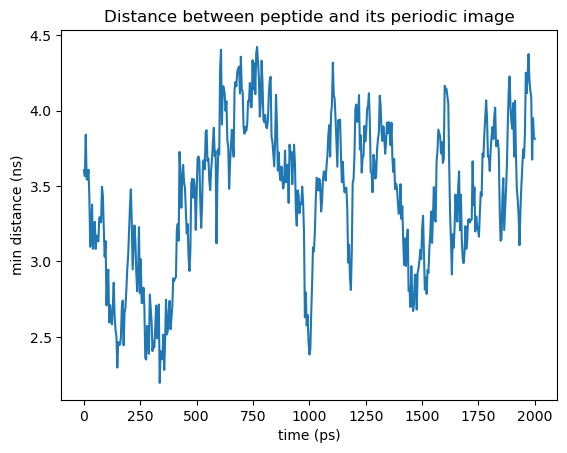

In [4]:

data = pd.read_table("../setup4/5-nvt-600-mindist.xvg", delim_whitespace=True, skiprows=29, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("min distance (ns)")  # Add a y-label to the axes.
ax.set_title("Distance between peptide and its periodic image")

print(y[131])

#### Extracting different confirmations

In [8]:
topology=f"../setup4/5-nvt-600.gro"
trajectory=f"../setup4/5-nvt-600-noPBC.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))
# trj.center_coordinates()
top = trj2.topology
# n_frames=trj.n_frames
# n_frames

In [9]:
# # https://stackoverflow.com/questions/63321109/algorithm-for-selecting-a-subset-of-most-distant-elements
def find_largest_values(trj, N, M):
    candidates = []  # List to store pairs (j, l(j))
    S_prime = []  # Resulting subset

    # Calculate pairwise distances and initialize candidates list
    for i in range(N):
            rmsd = md.rmsd(trj, trj, i)
#             print(rmsd)
            rmsd = np.delete(rmsd, i)

            l_i = min(rmsd)
            candidates.append((i, l_i))

    # Sort candidates list by l(i) in descending order
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Select M elements with the largest values of l(i)
    for i in range(M):
        current_index, current_l_value = candidates[i]
        S_prime.append(current_index)

    return S_prime

indxs = find_largest_values(trj2, trj2.n_frames, 120)
indxs

[4,
 8,
 239,
 3,
 0,
 72,
 21,
 22,
 52,
 57,
 37,
 385,
 89,
 71,
 413,
 430,
 429,
 88,
 368,
 70,
 53,
 68,
 69,
 163,
 36,
 96,
 95,
 38,
 39,
 330,
 331,
 62,
 43,
 44,
 405,
 443,
 263,
 29,
 61,
 1,
 2,
 79,
 40,
 108,
 276,
 282,
 412,
 377,
 118,
 143,
 166,
 106,
 107,
 32,
 497,
 484,
 428,
 150,
 28,
 65,
 478,
 17,
 275,
 356,
 459,
 460,
 66,
 67,
 461,
 252,
 132,
 369,
 370,
 50,
 51,
 226,
 438,
 439,
 294,
 479,
 26,
 27,
 283,
 284,
 375,
 376,
 498,
 290,
 147,
 35,
 253,
 5,
 299,
 56,
 112,
 442,
 80,
 81,
 16,
 15,
 23,
 129,
 128,
 357,
 258,
 259,
 78,
 77,
 329,
 341,
 342,
 116,
 117,
 431,
 499,
 500,
 219,
 398,
 409,
 434]

In [10]:
for i in range(40, 120):
    print(f"adding replica {i}")
    trj[indxs[i]].save(f'../production/r{i}/replica.gro')

adding replica 40
adding replica 41
adding replica 42
adding replica 43
adding replica 44
adding replica 45
adding replica 46
adding replica 47
adding replica 48
adding replica 49
adding replica 50
adding replica 51
adding replica 52
adding replica 53
adding replica 54
adding replica 55
adding replica 56
adding replica 57
adding replica 58
adding replica 59
adding replica 60
adding replica 61
adding replica 62
adding replica 63
adding replica 64
adding replica 65
adding replica 66
adding replica 67
adding replica 68
adding replica 69
adding replica 70
adding replica 71
adding replica 72
adding replica 73
adding replica 74
adding replica 75
adding replica 76
adding replica 77
adding replica 78
adding replica 79
adding replica 80
adding replica 81
adding replica 82
adding replica 83
adding replica 84
adding replica 85
adding replica 86
adding replica 87
adding replica 88
adding replica 89
adding replica 90
adding replica 91
adding replica 92
adding replica 93
adding replica 94
adding rep

#### Checking that the dihedrals are okay for all replicas

In [20]:
# Ensuring that all residues are in the trans confirmation
topology=f"../setup4/5-nvt-600.gro"
trajectory=f"../setup4/5-nvt-600-noPBC.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))

omega = md.compute_omega(trj2)
# omega[0]


In [54]:
print(len(omega))
print(len(omega[0]))
print(len(omega[1]))
print(omega[1][500])

for replica_indx in indxs:
    for angles in omega[1]:
        for angle in angles:
            if -0.3 < angle < 0.3:
                print(f'error in replica: {replica_indx}')

2
39
501
[ 2.8618689  3.1341205  2.8353229  3.0855641  2.744904   3.0903986
 -2.7890184 -2.8603213  3.016471   2.9257429 -3.079303   2.930856
 -2.936725  -3.1035347 -3.1221862  3.0916374  3.0388474  2.9053464
  2.9350076 -2.9589572  2.5622003 -3.1280773 -2.9739025 -2.9278398
 -3.0506823 -2.8122613  3.1412342  3.06947    3.1180558 -3.066726
  2.9569838  3.0712438  2.922096  -3.0873876 -2.838086   3.0666306
  2.761867   3.1335268 -3.0379405]


In [37]:
# checking the cis-trans configuration of confirmations after NVT and NPT equilibration
counter = 0

for i in range(40):
    structure = md.load(f"../production/r{i}/npt2.gro")
    omega = md.compute_omega(structure)
    print(f"checking replica {i}")
    angles = omega[1][0]
    indices = omega[0]
#     print(angles)
    flag = 0
    for j in range(len(angles)):
        angle = angles[j]
        if -2.79253 < angle < 2.79253:
            if flag == 0: 
                counter += 1
                flag = 1
                
            print(f'error in replica: {i} with residue {j}')
            print(indices[j])

counter

C:\Users\dell\anaconda3\envs\md\lib\site-packages\mdtraj\utils\validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


checking replica 0
checking replica 1
error in replica: 1 with residue 11
[168 180 182 184]
checking replica 2
error in replica: 2 with residue 7
[114 121 123 125]
checking replica 3
error in replica: 3 with residue 28
[439 442 444 446]
checking replica 4
error in replica: 4 with residue 20
[332 338 340 342]
error in replica: 4 with residue 33
[501 516 518 520]
checking replica 5
error in replica: 5 with residue 3
[41 57 59 61]
checking replica 6
error in replica: 6 with residue 3
[41 57 59 61]
checking replica 7
error in replica: 7 with residue 22
[357 365 367 369]
checking replica 8
error in replica: 8 with residue 19
[312 328 330 332]
checking replica 9
error in replica: 9 with residue 13
[201 214 216 218]
error in replica: 9 with residue 18
[292 308 310 312]
error in replica: 9 with residue 21
[342 353 355 357]
checking replica 10
checking replica 11
error in replica: 11 with residue 4
[61 81 83 85]
checking replica 12
error in replica: 12 with residue 9
[132 149 151 153]
checking 

25

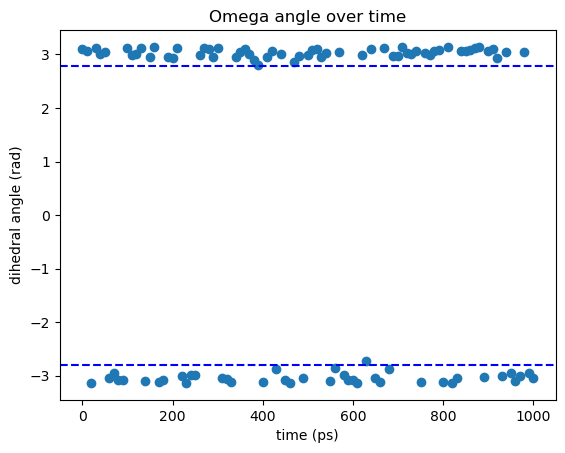

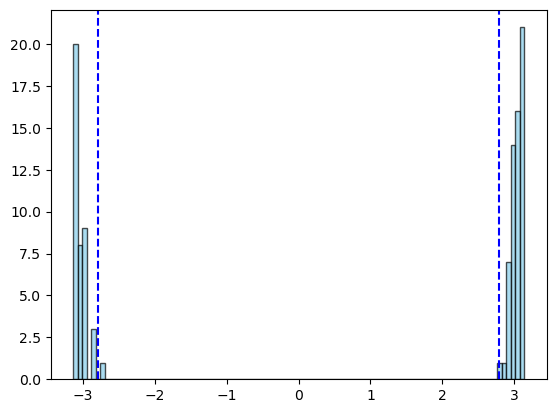

1
In frame 63, dihedral angle of residue 11 is -155.9201730900764


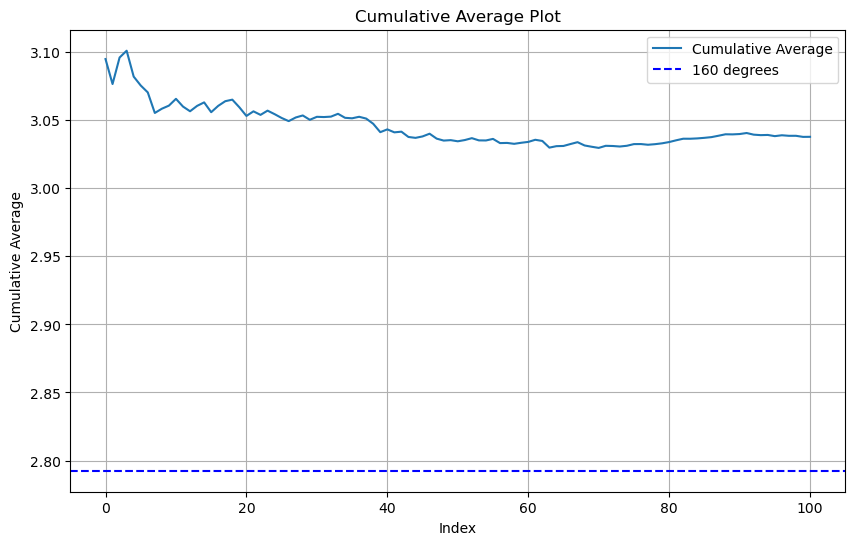

In [3]:
replica = 1
res = 11

angle = (160/180) * np.pi

topology=f"../production/r{replica}/npt.gro"
trajectory=f"../production/r{replica}/npt.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))

omega = md.compute_omega(trj2)
len(omega[1])

res_3_omega = [angles[res] for angles in omega[1]]
# res_3_omega

x = np.linspace(0, 1000, 101)

fig, ax = plt.subplots()
ax.scatter(x, res_3_omega)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("dihedral angle (rad)")  # Add a y-label to the axes.
ax.set_title("Omega angle over time")
plt.axhline(y=angle, color='b', linestyle='--')
plt.axhline(y=-1*angle, color='b', linestyle='--')
plt.show()

plt.hist(res_3_omega, bins=100, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(x=angle, color='b', linestyle='--')
plt.axvline(x=-1*angle, color='b', linestyle='--')
plt.show()

res_3_omega = np.array(res_3_omega)
outliers = np.where((res_3_omega > (-1 * angle)) & (res_3_omega < angle))

print(len(outliers[0]))
for i in range(len(outliers[0])):
    print(f"In frame {outliers[0][i]}, dihedral angle of residue {res} is {res_3_omega[outliers[0][i]] * 180/np.pi}")
    

res_3_omega = np.abs(res_3_omega)
cumulative_average = np.cumsum(res_3_omega) / np.arange(1, len(res_3_omega) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_average, label='Cumulative Average')
plt.xlabel('Index')
plt.ylabel('Cumulative Average')
plt.axhline(y=angle, color='b', linestyle='--', label = "160 degrees")
plt.title('Cumulative Average Plot')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Checking Ramachandran plot of the peptide
indxs[0]

4

plotting Ramachandran plot of Replica 0


C:\Users\dell\anaconda3\envs\md\lib\site-packages\MDAnalysis\coordinates\base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


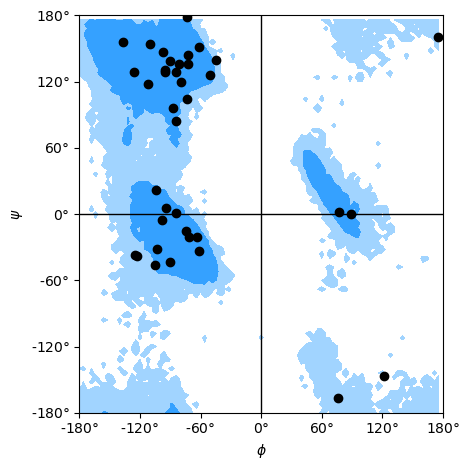

plotting Ramachandran plot of Replica 1


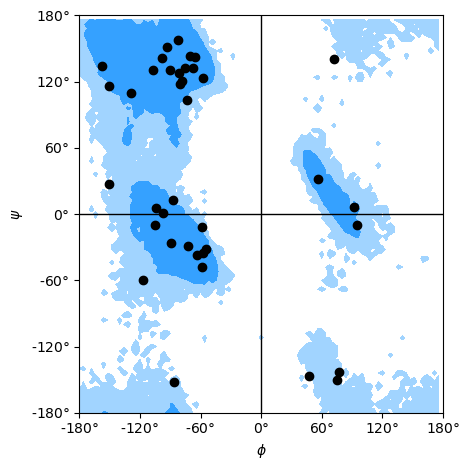

plotting Ramachandran plot of Replica 2


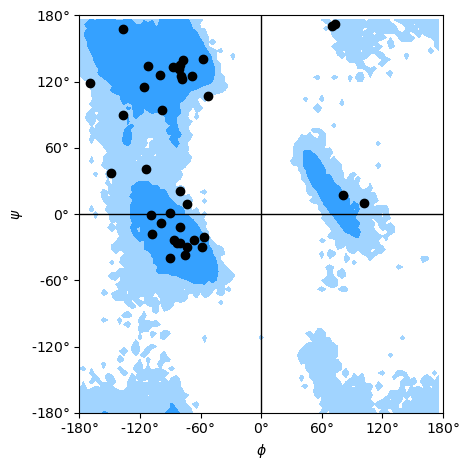

plotting Ramachandran plot of Replica 3


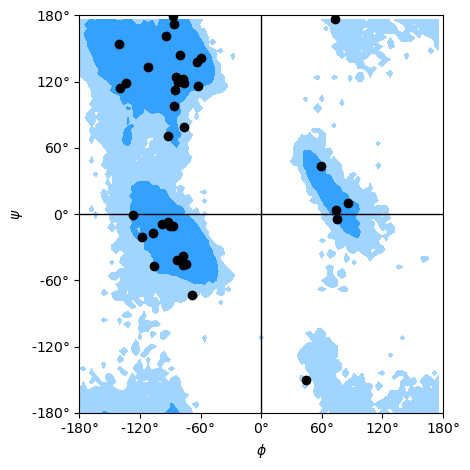

plotting Ramachandran plot of Replica 4


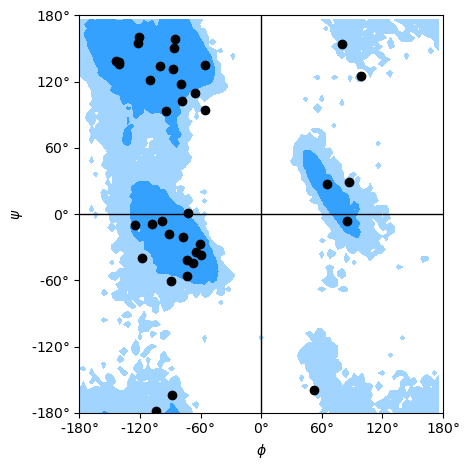

plotting Ramachandran plot of Replica 5


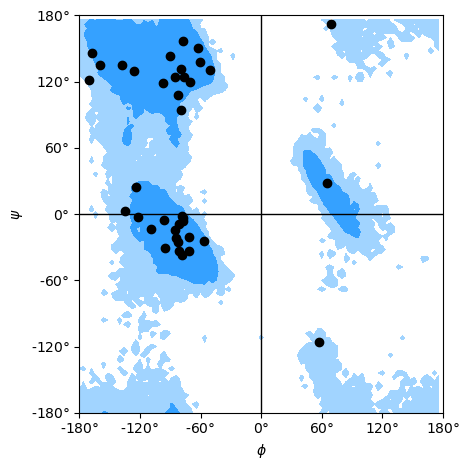

plotting Ramachandran plot of Replica 6


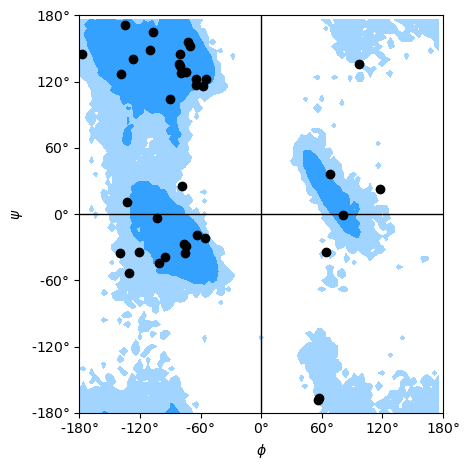

plotting Ramachandran plot of Replica 7


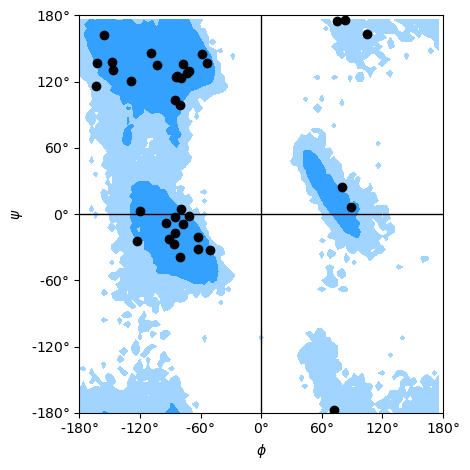

plotting Ramachandran plot of Replica 8


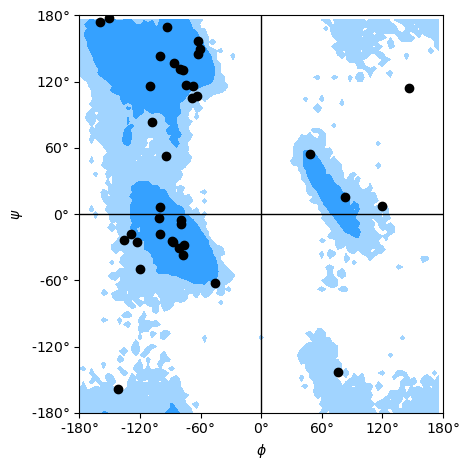

plotting Ramachandran plot of Replica 9


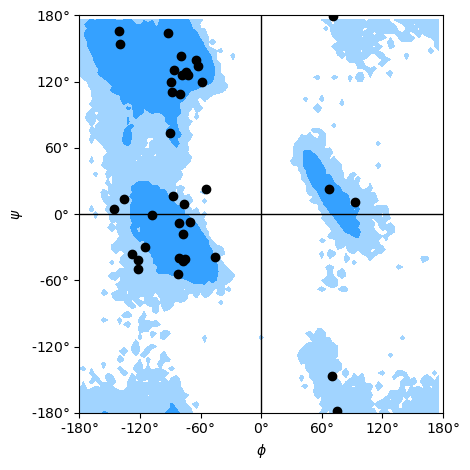

plotting Ramachandran plot of Replica 10


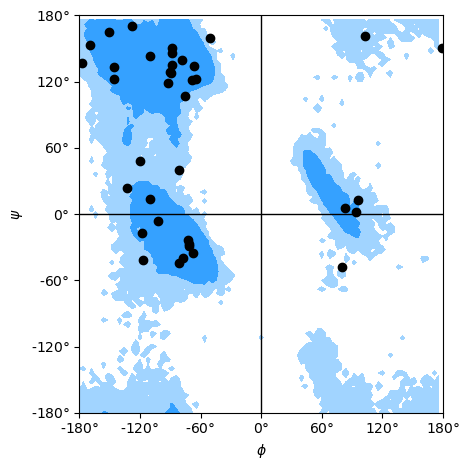

plotting Ramachandran plot of Replica 11


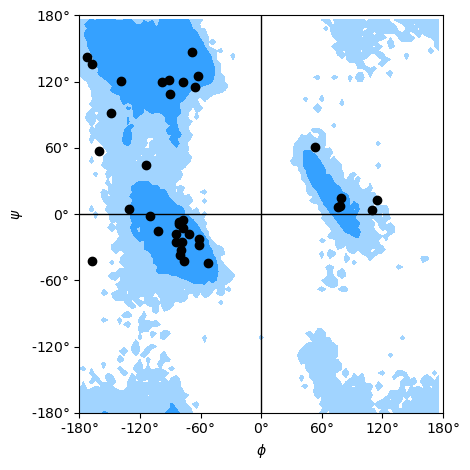

plotting Ramachandran plot of Replica 12


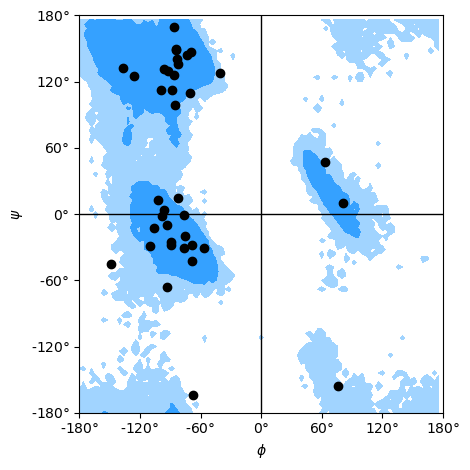

plotting Ramachandran plot of Replica 13


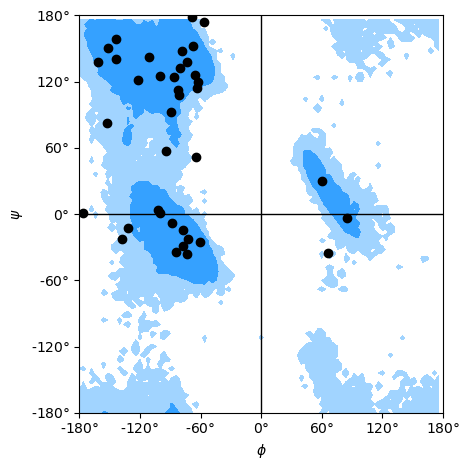

plotting Ramachandran plot of Replica 14


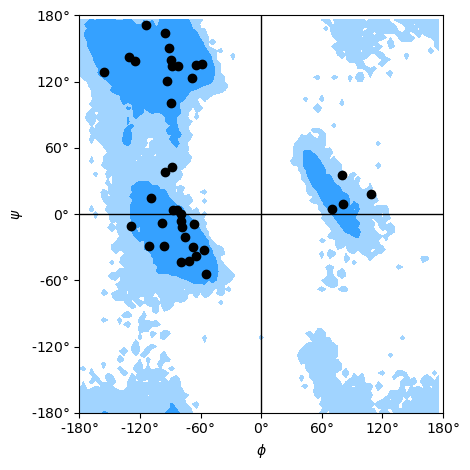

plotting Ramachandran plot of Replica 15


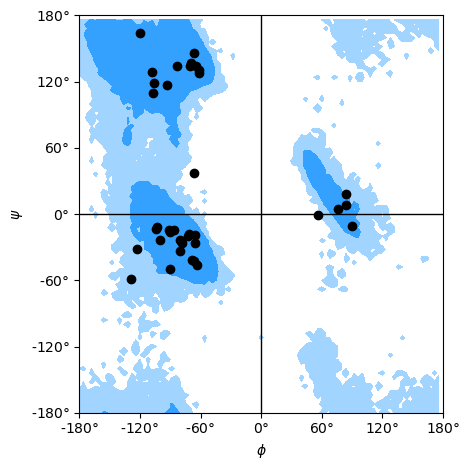

plotting Ramachandran plot of Replica 16


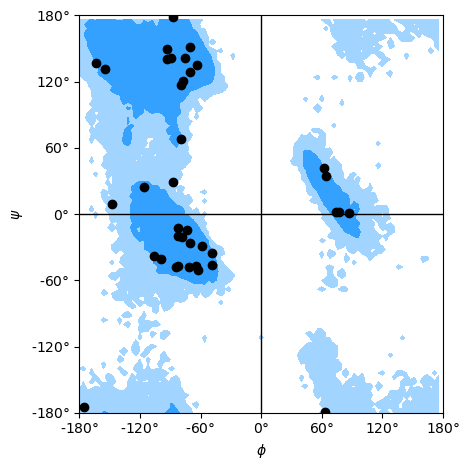

plotting Ramachandran plot of Replica 17


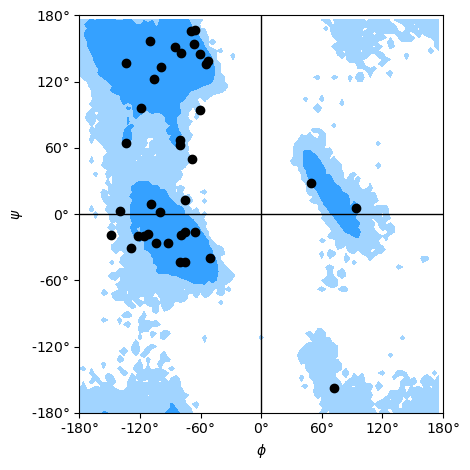

plotting Ramachandran plot of Replica 18


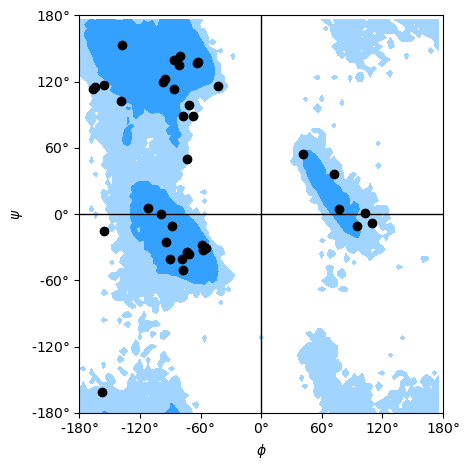

plotting Ramachandran plot of Replica 19


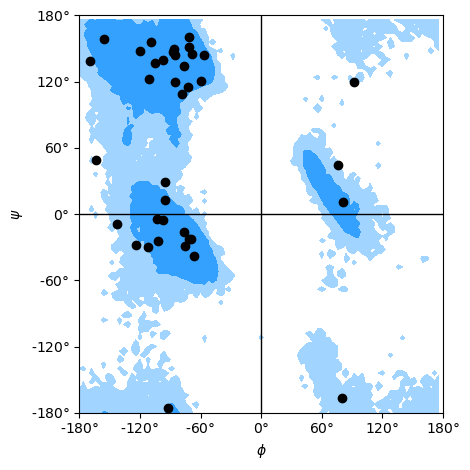

plotting Ramachandran plot of Replica 20


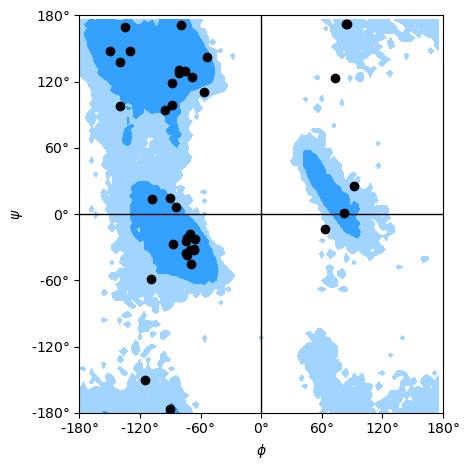

plotting Ramachandran plot of Replica 21


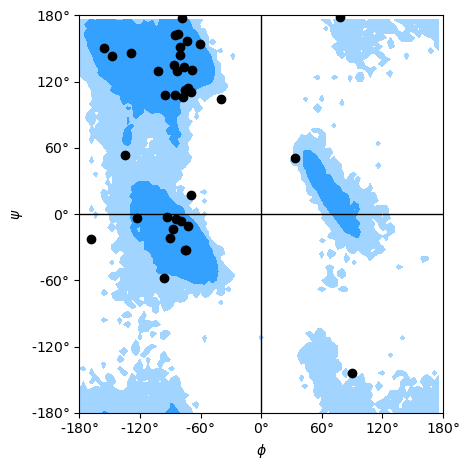

plotting Ramachandran plot of Replica 22


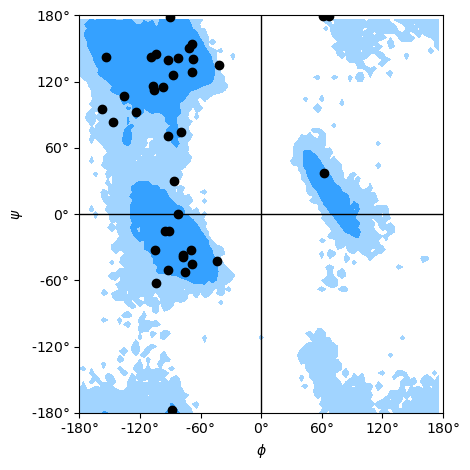

plotting Ramachandran plot of Replica 23


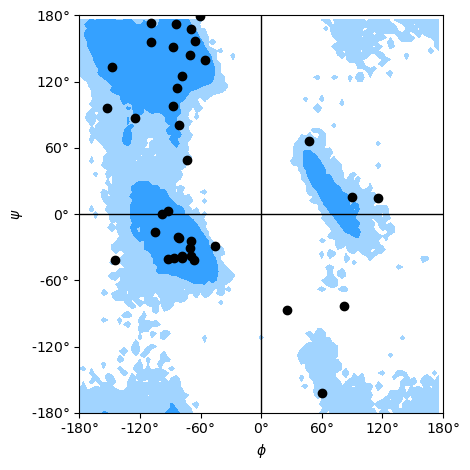

plotting Ramachandran plot of Replica 24


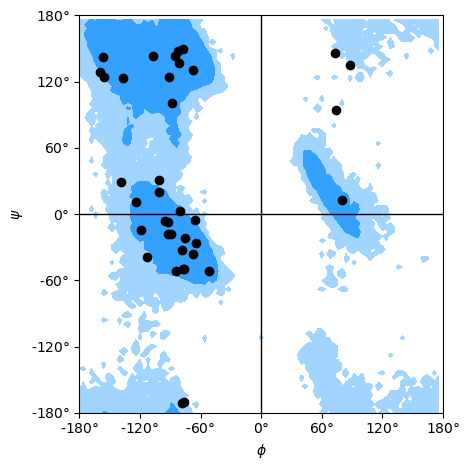

plotting Ramachandran plot of Replica 25


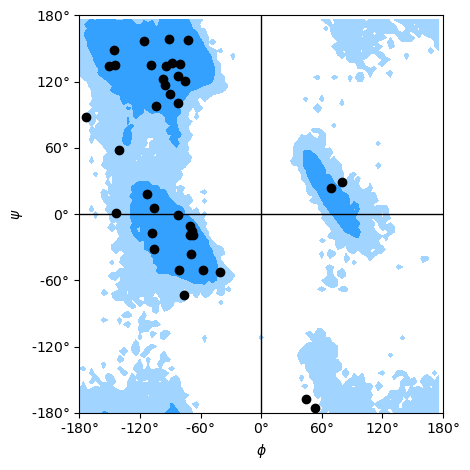

plotting Ramachandran plot of Replica 26


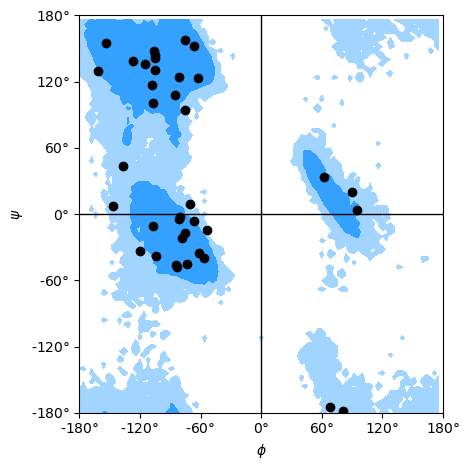

plotting Ramachandran plot of Replica 27


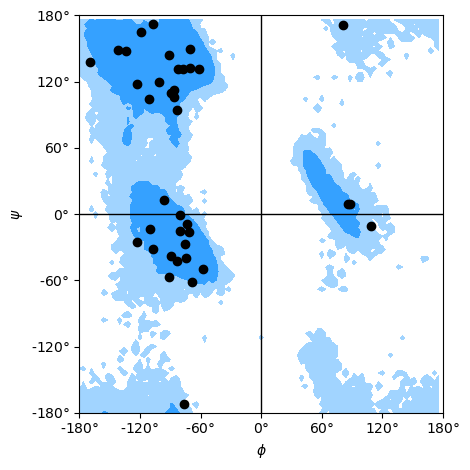

plotting Ramachandran plot of Replica 28


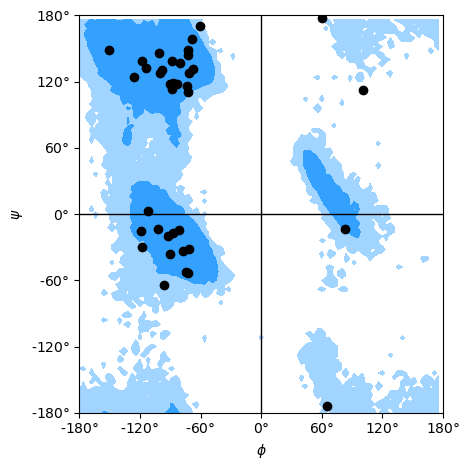

plotting Ramachandran plot of Replica 29


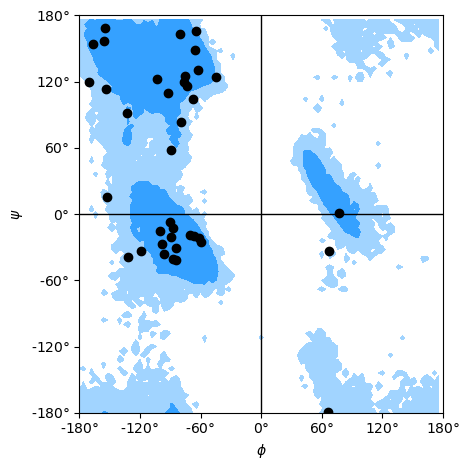

plotting Ramachandran plot of Replica 30


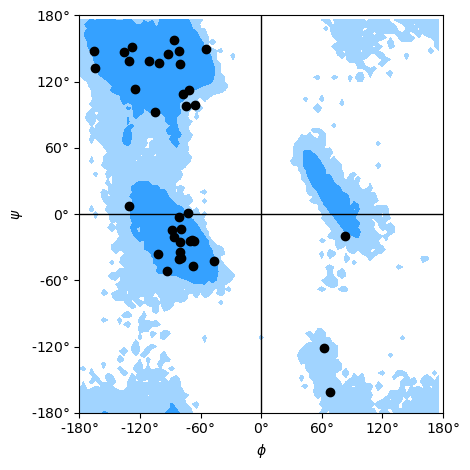

plotting Ramachandran plot of Replica 31


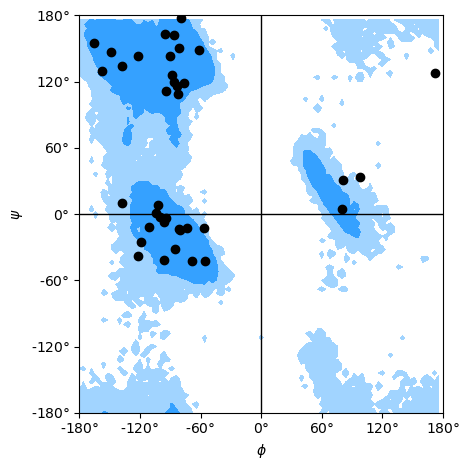

plotting Ramachandran plot of Replica 32


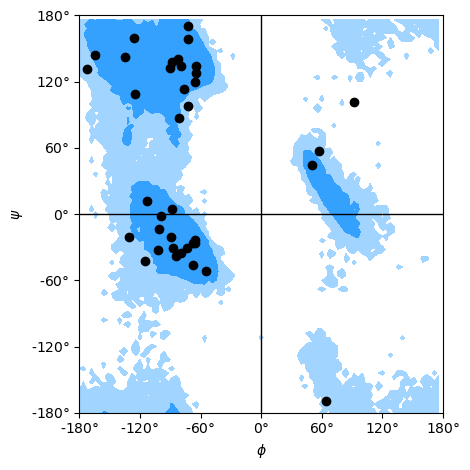

plotting Ramachandran plot of Replica 33


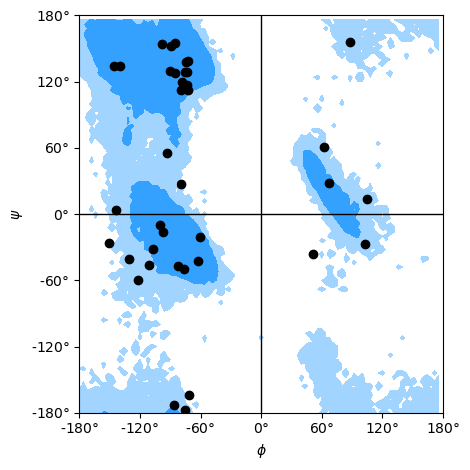

plotting Ramachandran plot of Replica 34


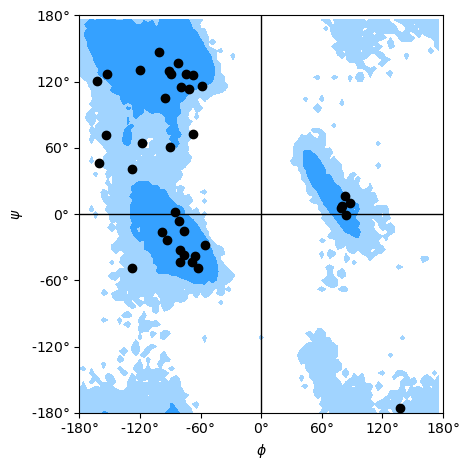

plotting Ramachandran plot of Replica 35


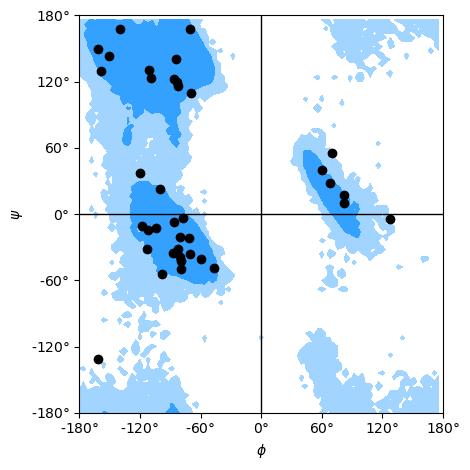

plotting Ramachandran plot of Replica 36


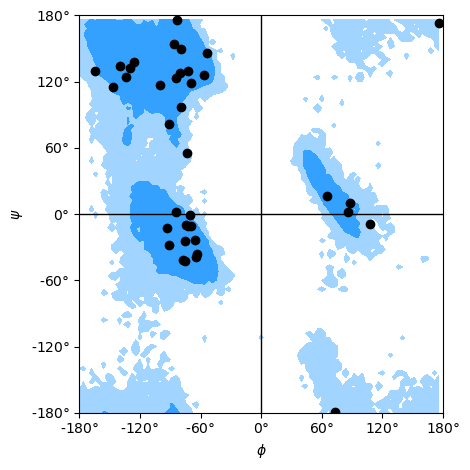

plotting Ramachandran plot of Replica 37


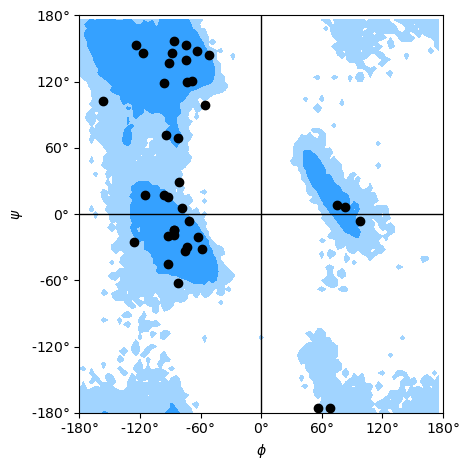

plotting Ramachandran plot of Replica 38


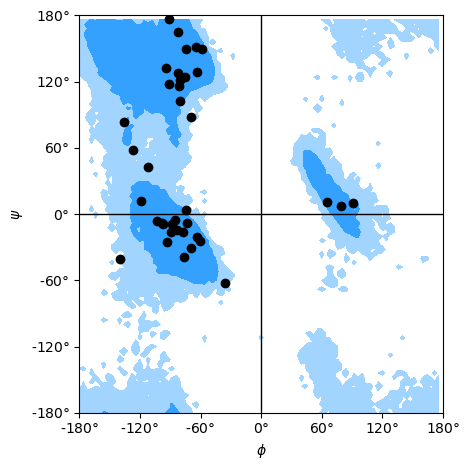

plotting Ramachandran plot of Replica 39


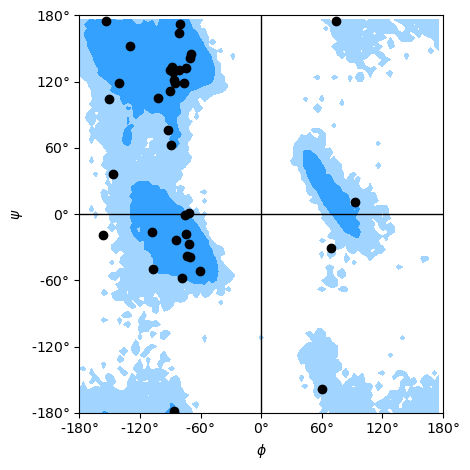

In [23]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis.dihedrals import Dihedral


# phis_indices = md.compute_phi(trj2)[0][indxs[0]]
# psis = md.compute_psi(trj2)[1][indxs[0]]
# phis = md.compute_phi(trj2)[1][indxs[0]]

# phis = phis[:38]
# psis = psis[1:]

# print(len(phis))
# print(len(psis))

# print("Ramachandran plot of replica 0")
# plt.figure(figsize=(8, 6))
# plt.scatter(phis * 180/3.14, psis * 180/3.14, s=10, color='blue', alpha=0.5)
# plt.xlim(-180, 180)
# plt.ylim(-180, 180)
# plt.xlabel('Phi (ϕ) angles')
# plt.ylabel('Psi (ψ) angles')
# plt.title('Ramachandran Plot')
# plt.grid(True)
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.show()

# u = mda.Universe(f'../production/r0/only_protein.gro')
# r = u.select_atoms("resid 1-40")


# phi_selection = [(res.phi_selection()) for res in r.residues]
# psi_selection = [(res.psi_selection()) for res in r.residues]
# dihedral_selection = [d for d in psi_selection if d]

# Calculate the dihedrals
# dihedrals = Dihedral(dihedral_selection).run()

# print(dihedrals.angles)


for i in range(40):
    # Load the protein structure from a .gro file
    print(f"plotting Ramachandran plot of Replica {i}")
    u = mda.Universe(f'../production/r{i}/npt2.gro')
    r = u.select_atoms("resid 2-39")

#     print(r.residues[0].resname)
    R = Ramachandran(r).run()
#     print(R.angles)

    fig, ax = plt.subplots(figsize=plt.figaspect(1))
    R.plot(ax=ax, color='k', marker='o', ref=True)
    
#     print(R.angles[0][0])
#     print(len(R.angles[0]))
#     for j in range(len(R.angles[0])):
#         if j != 39: continue
#         ax.annotate(f"{j}", (R.angles[0][j][0], R.angles[0][j][1]), textcoords="offset points", xytext=(0,5), ha='center')
    
    fig.tight_layout()
    plt.show()
    

approved_replicas = []


In [47]:
# checking that the collective variables are correct

structure = md.load("../production/r0/npt.gro").atom_slice(range(598))

ca = []
for residue in structure.topology.residues:
    for atom in residue.atoms:
        if atom.name == "CA":
            ca.append(str(atom.index+1))

ca = ",".join(ca)

cb = [19,44,171,260,279,295,315,335,372,449,459,478,504,523,540,570,586]

for residue in structure.topology.residues:
    for atom in residue.atoms:
        if atom.name == "CB" and (atom.index +1) in cb:
                print(f"Residue {residue.resSeq} {residue.name}: Atom index {atom.index+1}")

# checking arginine, lysine, glutamic acid, and aspartic acid functional group atom numbers
for residue in structure.topology.residues:
    atom_info = [(atom.index, atom.name) for atom in residue.atoms]
    print(f"Residue {residue.resSeq} {residue.name}: Atom indices and types {atom_info}")
    
    
# all looks good!

Residue 2 ALA: Atom index 19
Residue 4 PHE: Atom index 44
Residue 12 VAL: Atom index 171
Residue 17 LEU: Atom index 260
Residue 18 VAL: Atom index 279
Residue 19 PHE: Atom index 295
Residue 20 PHE: Atom index 315
Residue 21 ALA: Atom index 335
Residue 24 VAL: Atom index 372
Residue 30 ALA: Atom index 449
Residue 31 ILE: Atom index 459
Residue 32 ILE: Atom index 478
Residue 34 LEU: Atom index 504
Residue 35 MET: Atom index 523
Residue 36 VAL: Atom index 540
Residue 39 VAL: Atom index 570
Residue 40 VAL: Atom index 586
Residue 1 ASP: Atom indices and types [(0, 'N'), (1, 'H'), (2, 'H2'), (3, 'H3'), (4, 'CA'), (5, 'HA'), (6, 'CB'), (7, 'HB3'), (8, 'HB2'), (9, 'CG'), (10, 'OD1'), (11, 'OD2'), (12, 'C'), (13, 'O')]
Residue 2 ALA: Atom indices and types [(14, 'N'), (15, 'H'), (16, 'CA'), (17, 'HA'), (18, 'CB'), (19, 'HB1'), (20, 'HB2'), (21, 'HB3'), (22, 'C'), (23, 'O')]
Residue 3 GLU: Atom indices and types [(24, 'N'), (25, 'H'), (26, 'CA'), (27, 'HA'), (28, 'CB'), (29, 'HB3'), (30, 'HB2'),

In [ ]:
# after extracting 40 confirmations, setup the system for production run

# Carrying out NVT for 500 ps for each replica

# 1. NVT
gmx_mpi grompp -f ../mdp_files/6-nvt-278.mdp -c r0/replica.gro -p ../topol.top -o r0/nvt.tpr -maxwarn 3
for i in {41..119}; do gmx_mpi grompp -f ../mdp_files/6-nvt-278.mdp -c r${i}/replica.gro -p ../topol.top -o r${i}/nvt.tpr -maxwarn 3; done
gerun gmx_mpi mdrun -multidir r{40..119} -deffnm nvt -v -maxh 11 &> 6-nvt-278-terminal.log


# 3. NPT
gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r40/nvt.gro -p ../topol.top -o r40/npt.tpr -maxwarn 2
for i in {41..119}; do gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r${i}/nvt.gro -p ../topol.top -o r${i}/npt.tpr -maxwarn 2; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm npt -v &> 7-npt-278-terminal.log


# 3.2 NPT 2
gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r0/npt.gro -p ../topol.top -o r0/npt2.tpr -maxwarn 2
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r${i}/npt.gro -p ../topol.top -o r${i}/npt2.tpr -maxwarn 2; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm npt2 -v &> 8-npt-278-terminal.log

# 3.3 NPT 5 fs
gmx_mpi grompp -f ../mdp_files/9-npt-278-5fs.mdp -c r0/npt.gro -p ../topol.top -o r0/npt-5fs-test.tpr -maxwarn 2
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/9-npt-278-5fs.mdp -c r${i}/npt.gro -p ../topol.top -o r${i}/npt-5fs.tpr -maxwarn 2; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm npt-5fs -v &> 9-npt-278-5fs-terminal.log



In [ ]:
# extracting standard deviation of collective variables from NPT trajectories to define the width of potentials for metadynmaics

gmx_mpi editconf -f template.gro -o template.pdb

# changed OT1 to OT in template.pdb

for i in {0..39}; do plumed driver --mf_trr r${i}/npt2.trr --plumed ../../plumed/extract_colvars.dat; done
for i in {0..38}; do mv bck.${i}.COLVAR_FOR_SIGMA r${i}/COLVAR_FOR_SIGMA; done
 

for i in {0..39}; do sed -i 1,1d r${i}/COLVAR_FOR_SIGMA; done

for i in {0..39}; do cat r${i}/COLVAR_FOR_SIGMA >> COLVAR_FOR_SIGMA_ALL; done


COLVAR_FOR_SIGMA_ALL

In [5]:

data = pd.read_table("COLVAR_FOR_SIGMA_ALL", delim_whitespace=True, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")

helix = data[1]
beta = data[2]
rgyr = data[3]
hydro = data[4]
salt = data[5]
dihcor = data[6]

print(rgyr)
print(np.std(rgyr))

helix_std = np.std(helix) / 2
beta_std = np.std(beta) / 2
rgyr_std = np.std(rgyr) / 2
hydro_std = np.std(hydro) / 2
salt_std = np.std(salt) / 2
dihcor_std = np.std(dihcor) / 2


sigma = [helix_std, beta_std, rgyr_std, hydro_std, salt_std, dihcor_std]
sigma = np.round(sigma, decimals = 2)

print(sigma)

0       1.814646
1       1.836855
2       1.842854
3       1.824686
4       1.855819
          ...   
4035    1.525855
4036    1.538037
4037    1.531900
4038    1.535686
4039    1.549213
Name: 3, Length: 4040, dtype: float64
0.2353493909186317
[0.94 0.37 0.12 0.92 5.12 1.41]


### Using sigma values: [0.94 0.37 0.12 0.92 5.12 1.41]

In [29]:
# setting grid values for Collective Variables

# 1. helix.lessthan: min = 0, max = 35 (as blocks of 6 amino acids used for calculation. 35 maximum blocks possible)
# https://groups.google.com/g/plumed-users/c/5H8Wdl0mSCg

# 2. parabetarmsd
# https://groups.google.com/g/plumed-users/c/AL-o3dlbTHE/m/5lPgjctqKgAJ
# 3 res diff: len = 9; 40-9+1 = 32
# 4 res diff: len = 10; 40-10+1 = 31
# 5 res diff: len = 11; 40-11+1 = 30
# 34 res diff: len = 40; 40-40+1 = 1
# total_segments = 528
# total = 0
# for i in range(3, 35):
#     length = 6+i
#     n_segments = 40-length+1
#     total += n_segments
# print(total)

# 2. antibetarmsd
# total = 561
# total = 0
# for i in range(2, 35):
#     length = 6+i
#     n_segments = 40-length+1
#     total += n_segments
# print(total)

# 3. radius of gyration

# gmx_mpi gyrate -f template.gro -s template.gro -o gyrate.xvg
# Rg = 3.9 nm
# setting grid max to 4

# 4. hydrophobic residue contacts
# 17C2 = 136

# 5. salt bridges
# GROUPA=[10,11,12,35,36,37,108,109,110,162,163,164,351,352,353,363,364,365]
# GROUPB=[75,76,77,78,79,80,81,250,251,252,253,432,433,434,435]
# print(len(GROUPA) * len(GROUPB))
# GRID MAX should be around 270

# 6. sum of correlation between psi dihedral angles
# max possible value is 38

# my min max:
[0, 35], [0, 1089], [0, 3.9], [0, 136], [0, 270], [0, 38]

# Gabi's min max
# 100,100,20,200,400,50
[-1, 100], [-1, 100], [-1, 20], [-1, 200], [-1, 400], [-1, 50]

270


In [ ]:
# 4. Production Run trial for optimisation

gmx_mpi grompp -f ../mdp_files/production_run.mdp -c r0/npt.gro -p ../topol.top -o r0/production.tpr -maxwarn 3
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/production_run.mdp -c r${i}/npt.gro -p ../topol.top -o r${i}/production.tpr -maxwarn 3; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm nvt -v -maxh 11 &> 6-nvt-278-terminal.log


In [3]:
# rmsd = md.rmsd(trj2, trj2, 0)
# # print(max(rmsd))
# rmsd = md.rmsd(trj2, trj2, 0)

# # Find the index of the maximum value
# max_index = np.argmax(rmsd)
# max_index